# HDF 文件简介 — 以 FY4B_AGRI_L1 为例

## 1. HDF 文件是什么

HDF（**Hierarchical Data Format**）是一种通用的科学数据存储格式，广泛应用于遥感、气象、海洋、天文等领域。HDF 文件特点：

- **层级化存储**：数据以组（Group）和数据集（Dataset）组织，类似文件夹结构。
- **多类型数据支持**：支持多维数组、表格、标量、文本等。
- **自描述性**：每个数据集包含维度、数据类型、属性信息。
- **跨平台与语言支持**：Python (`h5py`, `pyhdf`), MATLAB, C/C++ 等均可读取。

HDF 常用在卫星遥感 L1、L2 数据中，如 FY4B_AGRI L1 卫星数据。
下载网站链接：https://fy4.nsmc.org.cn/

---

## 2. FY4B_AGRI L1 HDF 文件结构

以文件 `FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250801000000_20250801001459_4000M_V0001.HDF` 为例：

### 2.1 层级结构

HDF 文件一般分为：

- **根组 `/`**：包含全局属性（卫星、传感器、时间等）
- **数据组 `/Data` 或 `/DATA`**：存储各通道数据
  - 各通道以 `C01, C02 ... C15` 命名
  - 每个通道是二维数组 `[H,W]`，通常是浮点型或整型
- **质量标志组 `/QF` 或 `/QUALITY`**：存储数据质量信息
- **投影信息组 `/Geolocation`**：存储经纬度、投影、角度数据

---

## 3. 文件命名规则解析

FY4B_AGRI L1 文件命名规则一般为：
***FY4B-_AGRI–_N_DISK_1050E_L1-_FDI-_MULT_NOM_YYYYMMDDHHMMSS_YYYYMMDDHHMMSS_4000M_VXXXX.HDF***

### 各部分含义

| 字段 | 说明 |
|------|------|
| `FY4B` | 卫星名称（风云四号B星） |
| `_AGRI--_` | 传感器类型（AGRI：高分辨率可见光红外成像仪） |
| `N_DISK_1050E` | 扫描区域及子卫星信息（105°E 卫星地球同步子卫星） |
| `L1` | 数据级别（Level 1: 原始辐射定标数据） |
| `FDI` | 数据类型（Full Disk Image） |
| `MULT` | 数据模式（多通道、多分辨率） |
| `NOM` | 数据处理类型（NOM: 正规化观测产品） |
| `YYYYMMDDHHMMSS_YYYYMMDDHHMMSS` | 数据起止时间（UTC） |
| `4000M` | 空间分辨率（4000 米） |
| `V0001` | 文件版本号 |
| `.HDF` | 文件格式 |

示例：
**FY4B-_AGRI–_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250801000000_20250801001459_4000M_V0001.HDF**
- 起始时间：2025-08-01 00:00:00  
- 结束时间：2025-08-01 00:14:59  
- 分辨率：4000 米  
- 版本号：V0001  

---

## 4. Satpy 简介

**Satpy** 是一个 Python 库，用于读取、处理和可视化气象卫星遥感数据，特别适用于多卫星、多通道数据。

特点：
- **多卫星支持**：FY4B、Himawari、GOES、MODIS 等。
- **多数据级别**：L1、L2 产品。
- **数据重采样**：可以将不同卫星数据投影到统一网格。
- **通道合成**：自动生成 RGB 合成、真彩色/伪彩色图像。
- **易于可视化和输出**：支持 NumPy、PIL、Matplotlib、GeoTIFF 等格式。

示例：
```python
from satpy import Scene

files = ["FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250801000000_20250801001459_4000M_V0001.HDF"]
scn = Scene(filenames=files, reader="agri_fy4b_l1")

print("可用通道：", scn.available_dataset_names())
print("可用合成：", scn.available_composite_names())

scn.load(["C01", "C02", "C03"])  # 加载可见光 RGB 通道
rgb_array = scn["C01"].values  # 获取 numpy 数组

# 读取指定通道数据
c01_array = scn["C01"].values  # numpy array
# 设置重采样区域
from pyresample import create_area_def
area_def = create_area_def('custom', {'proj':'latlong'}, 
                          width=1024, height=1024, area_extent=(100,0,130,50))
custom_scn = scn.resample(area_def, resampler='nearest')
# 保存为npy
import numpy as np
np.save("FY4B_C01.npy", custom_scn["C01"].values)
# 保存为png
from PIL import Image
im = Image.fromarray((custom_scn["C01"].values*255).astype(np.uint8))
im.save("FY4B_C01.png")
```

In [1]:
# ======================
# 0. 导入依赖
# ======================
from satpy import Scene
from pyresample import create_area_def
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in")

print("库导入完成")

库导入完成


In [2]:
# ======================
# 1. 设置文件路径
# ======================
output_dir = "/data/xmr/xmrcode/data_process/data/output/fy4b"

# 示例：直接指定 FY4B HDF 文件
files = ['/data/xmr/xmrcode/data_process/data/fy4b/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250801000000_20250801001459_4000M_V0001.HDF']

print("找到的文件数量:", len(files))
print("文件列表:", files[:3])  # 只打印前3个，避免太长

找到的文件数量: 1
文件列表: ['/data/xmr/xmrcode/data_process/data/fy4b/FY4B-_AGRI--_N_DISK_1050E_L1-_FDI-_MULT_NOM_20250801000000_20250801001459_4000M_V0001.HDF']


In [3]:
scn = Scene(filenames=files, reader='agri_fy4b_l1')

print("Scene 创建完成")
print("可用通道：", scn.available_dataset_names())
print("可用合成：", scn.available_composite_names())

# 加载自然彩色
scn.load(['natural_color'])

# 也可以手动加载单通道 RGB，例如:
# scn.load(['C01','C02','C03'])

Scene 创建完成
可用通道： ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15']


Too many possible datasets to load for DataQuery(wavelength=3.9)
Too many possible datasets to load for DataQuery(wavelength=3.9)
Too many possible datasets to load for DataQuery(wavelength=3.9)
Too many possible datasets to load for DataQuery(wavelength=3.9)
Too many possible datasets to load for DataQuery(wavelength=3.9)
Too many possible datasets to load for DataQuery(wavelength=3.9)
Too many possible datasets to load for DataQuery(wavelength=3.9)
Required file type 'agri_l1_4000m_geo' not found or loaded for 'solar_zenith_angle'


可用合成： ['ash', 'cimss_cloud_type', 'cimss_cloud_type_raw', 'cloud_phase', 'cloud_phase_distinction', 'cloud_phase_distinction_raw', 'cloud_phase_raw', 'color_infrared', 'day_microphysics', 'day_microphysics_agri', 'day_microphysics_eum', 'dust', 'fire_temperature_awips', 'fog', 'green', 'green_nocorr', 'green_snow', 'ir108_3d', 'ir_cloud_day', 'land_cloud', 'land_cloud_fire', 'natural_color', 'natural_color_raw', 'natural_enh', 'overview', 'overview_raw', 'pseudored', 'pseudored_nocorr', 'snow', 'snow_fog', 'true_color', 'true_color_nocorr']


In [4]:
# ======================
# 3. 定义自定义区域（等经纬度投影）
# ======================
area_id = 'custom_latlon'
description = 'Custom LatLon Area'
proj_dict = {'proj': 'latlong'}  # 等经纬度投影

# 示例：中国海区域 (min_lon, min_lat, max_lon, max_lat)
# area_extent = (140, -45, 152.8, -32.2)
area_extent = (116.2, 28.7, 129.0, 41.5)
# [28.7, 41.5, 116.2, 129.0, 0.0125]
width = 1024
height = 1024

area_def = create_area_def(area_id, proj_dict,
                           width, height, area_extent)

print("区域定义完成")
print("区域范围:", area_extent)
print("分辨率 (像素数):", width, "x", height)

区域定义完成
区域范围: (116.2, 28.7, 129.0, 41.5)
分辨率 (像素数): 1024 x 1024


In [5]:
# ======================
# 4. 重采样到自定义区域
# ======================
custom_scn = scn.resample(area_def, resampler='nearest')  # 或 'bilinear'

print("重采样完成")
print("重采样后可用数据集:", custom_scn.keys())

重采样完成
重采样后可用数据集: [DataID(name='natural_color', resolution=4000)]


True Color image saved at /data/xmr/xmrcode/data_process/data/output/fy4b/output.png


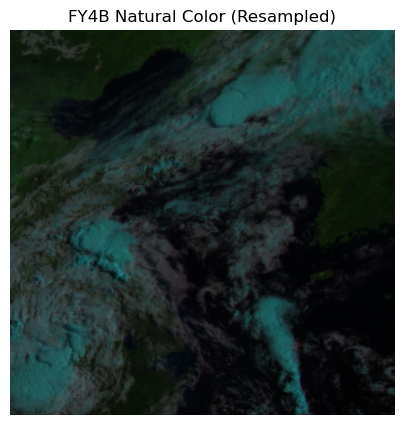

In [6]:
# ======================
# 6. 保存并可视化输出图像
# ======================
output_path = os.path.join(output_dir,'output.png')
custom_scn.save_dataset('natural_color', output_path)
print(f"True Color image saved at {output_path}")

# 使用 matplotlib 可视化
# custom_scn['natural_color'] = custom_scn['natural_color'] ** (1 / 2.2)
img = custom_scn['natural_color'].to_numpy()
plt.figure(figsize=(5, 5))
img = img.transpose(1, 2, 0)
img_norm = img/255
plt.imshow(img_norm)
plt.title("FY4B Natural Color (Resampled)")
plt.axis("off")
plt.show()

In [7]:
# 保存为npy格式数据
scn = Scene(filenames=files, reader='agri_fy4b_l1')

print("Scene 创建完成")
print("可用通道：", scn.available_dataset_names())
print("可用合成：", scn.available_composite_names())
# 也可以手动加载单通道 RGB，例如:
scn.load(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15'])

Too many possible datasets to load for DataQuery(wavelength=3.9)
Too many possible datasets to load for DataQuery(wavelength=3.9)
Too many possible datasets to load for DataQuery(wavelength=3.9)


Too many possible datasets to load for DataQuery(wavelength=3.9)
Too many possible datasets to load for DataQuery(wavelength=3.9)
Too many possible datasets to load for DataQuery(wavelength=3.9)
Too many possible datasets to load for DataQuery(wavelength=3.9)


Scene 创建完成
可用通道： ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15']
可用合成： ['ash', 'cimss_cloud_type', 'cimss_cloud_type_raw', 'cloud_phase', 'cloud_phase_distinction', 'cloud_phase_distinction_raw', 'cloud_phase_raw', 'color_infrared', 'day_microphysics', 'day_microphysics_agri', 'day_microphysics_eum', 'dust', 'fire_temperature_awips', 'fog', 'green', 'green_nocorr', 'green_snow', 'ir108_3d', 'ir_cloud_day', 'land_cloud', 'land_cloud_fire', 'natural_color', 'natural_color_raw', 'natural_enh', 'overview', 'overview_raw', 'pseudored', 'pseudored_nocorr', 'snow', 'snow_fog', 'true_color', 'true_color_nocorr']


In [8]:
custom_scn = scn.resample(area_def, resampler='nearest')  # 或 'bilinear'

print("重采样完成")
print("重采样后可用数据集:", custom_scn.keys())

重采样完成
重采样后可用数据集: [DataID(name='C01', wavelength=WavelengthRange(min=0.45, central=0.47, max=0.49, unit='µm'), resolution=4000, calibration=<calibration.reflectance>, modifiers=()), DataID(name='C02', wavelength=WavelengthRange(min=0.55, central=0.65, max=0.75, unit='µm'), resolution=4000, calibration=<calibration.reflectance>, modifiers=()), DataID(name='C03', wavelength=WavelengthRange(min=0.75, central=0.83, max=0.9, unit='µm'), resolution=4000, calibration=<calibration.reflectance>, modifiers=()), DataID(name='C04', wavelength=WavelengthRange(min=1.36, central=1.37, max=1.39, unit='µm'), resolution=4000, calibration=<calibration.reflectance>, modifiers=()), DataID(name='C05', wavelength=WavelengthRange(min=1.58, central=1.61, max=1.64, unit='µm'), resolution=4000, calibration=<calibration.reflectance>, modifiers=()), DataID(name='C06', wavelength=WavelengthRange(min=2.1, central=2.22, max=2.35, unit='µm'), resolution=4000, calibration=<calibration.reflectance>, modifiers=()), DataID

In [9]:
# 按照通道顺序列出你要保存的通道
channels = ['C01','C02','C03','C04','C05','C06','C07','C08','C09','C10',
            'C11','C12','C13','C14','C15']

# 检查 custom_scn 中是否有这些通道
available_channels = [ch for ch in channels if ch in custom_scn]
print("实际可用通道:", available_channels)

# 按顺序堆叠成 numpy array: shape = [C,H,W]
stacked = np.stack([custom_scn[ch].values for ch in available_channels], axis=0)

print("堆叠后的 shape:", stacked.shape)

# 保存为 npy
np.save("/data/xmr/xmrcode/data_process/data/output/fy4b/output.npy", stacked)
print("✅ 保存完成")

实际可用通道: ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15']
堆叠后的 shape: (15, 1024, 1024)
✅ 保存完成
